TP: Apprentissage par renforcement
============

Introduction au sujet
------

L'objectif de ce sujet est d'étudier des techniques d’apprentissage par renforcement sur un jeu simple nommé *Frozenlake*. Nous verrons à travers ce TP les bases de l’utilisation de la librairie `gymnasium`.

Le code est à écrire en python3 à la suite des questions dans ce fichier. 

N'hésitez pas à regarder régulièrement la documentation des librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

Langage utilisé:
- Python 3: https://docs.python.org/3/

Librairie de math:
- Numpy: https://docs.scipy.org/doc/numpy/reference/

Librairie d'affichage de données:
- Matplotilb: https://matplotlib.org/contents.html

Librairie de problèmes d’apprentissage par renforcement:
- Gymnasium: https://gymnasium.farama.org/

Commencez par importer les librairies nécessaires au TP.

In [280]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import ipywidgets as widgets

#import copy 
import random

#from sklearn.neural_network import MLPRegressor
import torch
from collections import deque

# Présentation de Gymnasium

Gymnasium est une bibliothèque open-source créée à partir de la librairie Gym. Elle est maintenue et développée par la fondation Farama. Elle implémente une grande diversité d’environnements (pendule inversé, jeux Atari, robots…) avec une interface unifiée pour faciliter la comparaison d’algorithmes d’apprentissage par renforcement. Cette bibliothèque est couramment utilisée pour tester des algorithmes de renforcement et est souvent utilisée en combinaison avec la bibliothèque [Stable-Baselines](https://stable-baselines3.readthedocs.io) (que nous n’aborderons pas dans ce TP) qui fournit une implémentation des principaux algorithmes à l’état de l’art.

Dans ce TP, nous allons implémenter un agent évoluant dans l’environnement [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/). En vous référant à la documentation, écrivez un paragraphe de présentation de cet environnement. Vous préciserez notamment les actions disponibles, les états possibles, les récompenses existantes et les conditions d’arrêts.

Quelles sont les conséquences de l’attribut `is_slippery` sur l’environnement ? 

Nous allons commencer par générer une carte de jeu au format texte. Pour cela utilisez la fonction `generate_random_map` que vous stockerez dans une variable. Vous construirez une carte de taille $4\times 4$ avec la graine du génératoire aléatoire fixé à 42. Vous mettrez `p` à 0.9 . 

In [281]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

random_map = generate_random_map(size=4,p=0.9,seed=42)

Affichez le tableau généré par la question précédente. Expliquez à quels types de cases sont associées chaque lettre.

In [282]:
print(random_map)

['SFFF', 'FHFF', 'FFFH', 'FFFG']


Nous allons maintenant créer le moteur du jeu. Pour cela créez une variable `env` à l’aide de la fonction [*make*](https://gymnasium.farama.org/api/registry/#gymnasium.make) de `gym`. Vous utiliserez l’environnement `FrozenLake-v1` avec:
- l’attribut `is_slippery` à Faux,
- le `render_mode` sur `human`,
- `desc` contiendra la carte textuelle créée précédemment. 

In [283]:
import gymnasium as gym

env = gym.make('FrozenLake-v1', desc=random_map, map_name="4x4", render_mode="human", is_slippery=False)

En regardant les valeurs des attributs `action_space.n` et `observation_space.n` de la variable `env`, vérifiez que le nombre d’action et d’état sur cet environnement est compatible à la description que vous aviez faite de l’environnement.

In [284]:
print("Nombre d’actions possibles:",env.action_space.n)
print("Nombre d’état possibles:",env.observation_space.n)

Nombre d’actions possibles: 4
Nombre d’état possibles: 16


Lancez le rendu graphique de l’environnement. Pour cela vous devez tout d’abord initialiser l’environnement avec la méthode `reset` puis lancer le rendu avec `render` (ne fermez pas la nouvelle fenêtre qui s’ouvrira, cela pourrait tuer le kernel python ).

In [285]:
env.reset()
env.render()

Pour effectuer une action il suffit de passer un numéro d’action à la méthode `step`. Effectuez un déplacement vers le bas. Expliquez ce que retourne cette méthode.

In [286]:
env.step(2)

(1, 0.0, False, False, {'prob': 1.0})

Lisez le code suivant utilisant la librairie [widget](https://ipywidgets.readthedocs.io/en/stable/) de jupyter et commentez chaque ligne pour indiquer les opérations réalisées.

In [287]:
# Création d'un bouton avec le texte "Ok"
btn = widgets.Button(description='Ok')

# Création d'un label avec le texte "Appuyer sur OK"
labelWidget = widgets.Label(value='Appyer sur OK')

# Affichage du bouton
display(btn)

# Affichage du label 
display(labelWidget)

# Fonction de gestionnaire d'événement de clic de bouton
def btn_eventhandler(obj, txt):
    # Cache le bouton après qu'il a été cliqué
    btn.layout.visibility = 'hidden'
    # Change le texte du label pour le texte spécifié
    labelWidget.value = txt

# Ajout d'un gestionnaire d'événement de clic pour le bouton,
# qui appelle la fonction btn_eventhandler avec le texte "OK" lorsqu'il est cliqué
btn.on_click(lambda o: btn_eventhandler(o, 'OK'))


Button(description='Ok', style=ButtonStyle())

Label(value='Appyer sur OK')

Après avoir réinitialisé l’environnement écrivez une interface basique à l’aide de 4 boutons et un label pour jouer au jeu associé à l’environnement. Vous afficherez `Perdu` si vous tombez dans l’eau et `Gagné` lorsque le trésor et trouvé. Faite en sorte que les boutons disparaissent en fin de partie.

In [288]:
def btn_step_eventhandler(env, step): 
    
    # Effectuer l'action dans l'environnement
    step_result = env.step(step)
    print("Résultat de l'action :", step_result)  # Afficher le résultat de l'action pour voir sa structure
    
    # Extraire les informations pertinentes du résultat de l'action
    observation = step_result[0]
    reward = step_result[1]
    done = step_result[2]
    
    # Vérifier si le jeu est terminé
    if done:
        # Si l'agent est tombé dans l'eau, afficher "Perdu"
        if reward == 0.0:
            print("Perdu")
        # Si l'agent a trouvé le trésor, afficher "Gagné"
        elif reward == 1.0:
            print("Gagné")
        
        # Cacher les boutons
        grid.layout.visibility = 'hidden'


# Créer des boutons pour chaque direction
btn_Gauche = widgets.Button(description='←')
btn_Gauche.on_click(lambda o: btn_step_eventhandler(env, 0))

btn_Bas = widgets.Button(description='↓')
btn_Bas.on_click(lambda o: btn_step_eventhandler(env, 1))

btn_Droite = widgets.Button(description='→')
btn_Droite.on_click(lambda o: btn_step_eventhandler(env, 2))

btn_Haut = widgets.Button(description='↑')
btn_Haut.on_click(lambda o: btn_step_eventhandler(env, 3))

# Création d'une disposition en grille pour les boutons
grid = widgets.GridspecLayout(3, 3)

# Ajout des boutons à la disposition en grille
grid[0, 1] = btn_Haut  # Bouton du haut
grid[1, 0] = btn_Gauche  # Bouton de gauche
grid[1, 2] = btn_Droite  # Bouton de droite
grid[2, 1] = btn_Bas  # Bouton du bas

# Affichage de la disposition en grille
display(grid)


GridspecLayout(children=(Button(description='↑', layout=Layout(grid_area='widget001'), style=ButtonStyle()), B…

Il est possible d’avoir un rendu sous la forme d’image qui pourront être affichés via `matplotlib`. Pour cela il suffit de changer l’attribut `render_mode` lors de la création de l’environnement par `rgb_array`. À l’aide d’une liste d’actions et d’une boucle `for` affichez une séquence d’image permettant d’atteindre le trésor. L’appel à `render` doit être effectué pour générer chaque image.

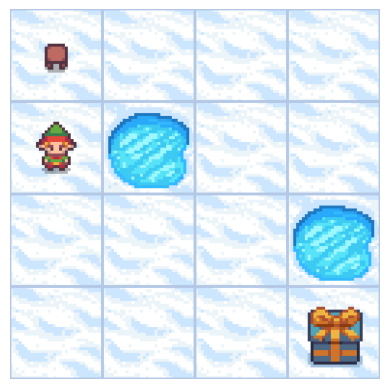

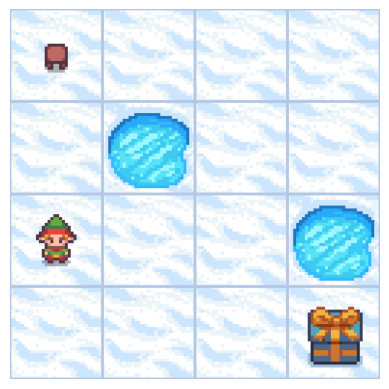

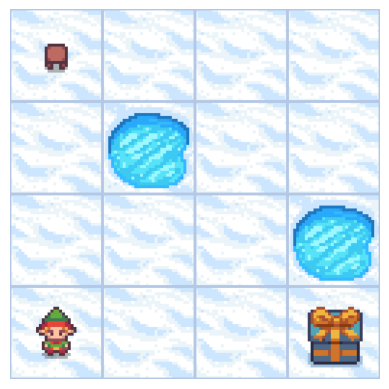

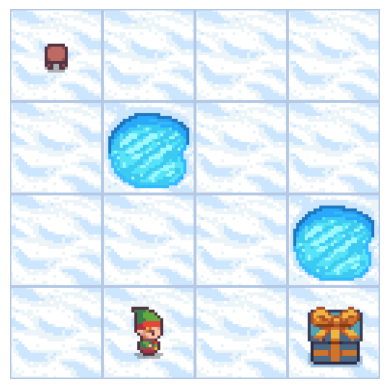

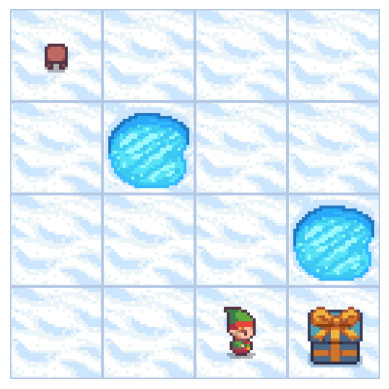

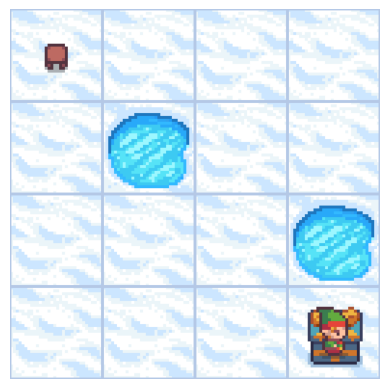

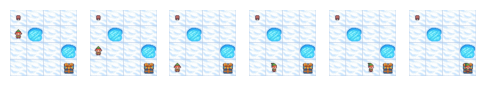

In [289]:
env_plt = gym.make('FrozenLake-v1', desc=random_map, map_name="4x4", render_mode="rgb_array", is_slippery=False)
actions = [1, 1, 1, 2, 2, 2]

env_plt.reset()

frames = []

# Boucle sur les actions
for step in actions:
    # Exécution de l'action dans l'environnement
    env_plt.step(step)
    
    # Rendu de l'environnement et stockage de l'image
    frame = env_plt.render()
    frames.append(frame)

    # Affichage de l'image
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

# Affichage de la séquence d'images
fig, ax = plt.subplots(1, len(frames), figsize=(len(frames), 1))
for i, frame in enumerate(frames):
    ax[i].imshow(frame)
    ax[i].axis('off')


plt.show()

Dans la suite on pourra utiliser la valeur `None` pour l’attribut `render_mode`, cela permet de ne pas générer de rendu graphique et accéléra les calculs.

# SARSA

Dans cette partie, nous allons implémenter l’algorithme SARSA vu en cours.

Déclarez une classe `Qtable` permettant la gestion d’une QTable . Cette classe aura les méthodes suivantes:
- un constructeur sauvegardant tous les paramètres pour la création de la QTable.
- une méthode `get_qtable` retournant la Qtable courante
- une méthode `get_best_action` prenant l’état courant et l’environnement et retournant la meilleure action à faire en suivant la politique. Si toutes les valeurs de la QTable sont toutes identiques pour l’état courant, l’action est tirée au hasard en utilisant la méthode `sample` de l’`env.action_space`.
- une méthode `reset_qtable` remettant à zéros les valeurs de la qtable. Cette méthode sera appelée par le constructeur.

In [290]:
class QTable:
    
    def __init__(self, num_states, num_actions):
        self.q_table = np.zeros((num_states, num_actions))

    def get_qtable(self):
        return self.q_table

    def get_best_action(self, state, env):
        """
        Retourne la meilleure action à faire en suivant la politique.

        Args:
            state: L'état courant.
            env: L'environnement Gym.

        Returns:
            int: L'action choisie.
        """
        # Obtenir les valeurs Q pour l'état donné
        q_values = self.q_table[state]

        # Si toutes les valeurs de la QTable sont identiques, choisir une action aléatoire
        if np.all(q_values == q_values[0]):
            action = env.action_space.sample()
        # Sinon, choisir l'action avec la plus grande valeur Q
        else:
            action = np.argmax(q_values)

        return action

Déclarez une classe `Sarsa` permettant de gérer l’algorithme du même nom. Cette classe héritera de la classe `Qtable`  et aura notamment les méthodes suivantes:
- un constructeur sauvegardant tous les paramètres de l’algorithme.
- une méthode `update` prenant en argument l’état courant, l’état suivant, l’action permettant de passer de l’état courant à l’état suivant, l’action suivante selon la politique et la récompense obtenu lors de la transition entre les deux états. Cette fonction met à jours la Qtable en suivant la règle de mise à jours de SARSA.

In [291]:
class Sarsa(QTable):
    
    def __init__(self, state_size, action_size, learning_rate=0.1, epsilon=0.1):
        """
        Constructeur de la classe Sarsa.

        Args:
            state_size (int): Taille de l'espace des états.
            action_size (int): Taille de l'espace des actions.
            learning_rate (float): Taux d'apprentissage (par défaut : 0.1).
            epsilon (float): Paramètre epsilon pour la politique epsilon-greedy (par défaut : 0.1).
        """
        
        super().__init__(state_size, action_size)
        self.learning_rate = learning_rate
        self.epsilon = epsilon

    def update(self, state, next_state, action, next_action, reward):
        """
        Met à jour la QTable en suivant la règle de mise à jour de SARSA.
        
        Args:
            state: L'état courant.
            next_state: L'état suivant.
            action: L'action prise dans l'état courant.
            next_action: L'action suivante selon la politique.
            reward: La récompense obtenue lors de la transition entre les deux états.
        """
        
        # Obtenir la valeur Q pour l'action choisie dans l'état courant
        current_q_value = self.q_table[state, action]
        
        # Obtenir la valeur Q pour l'action suivante dans l'état suivant
        next_q_value = self.q_table[next_state, next_action]
        
        # Calcul de la cible de la mise à jour SARSA
        target = reward + next_q_value
        
        # Mise à jour de la valeur Q pour l'action choisie dans l'état courant
        updated_q_value = current_q_value + self.learning_rate * (target - current_q_value)
        
        # Mettre à jour la QTable avec la nouvelle valeur Q
        self.q_table[state, action] = updated_q_value


Nous allons maintenant coder la stratégie $\epsilon$-gloutonne. Déclarez une classe `EpsilonGreedy` ayant les méthodes suivantes:
- un constructeur sauvegardant la valeur de $\epsilon$ et la QTable à utiliser.
- une méthode `choose_action` prenant en argument l’état courant et l'environnement. Cette méthode retourne l’action à faire suivant l’algorithme $\epsilon$-glouton. Vous pourrez utiliser `sample` de l’environnement pour tirer au hasard une action.

In [292]:
class EpsilonGreedy:
    
    def __init__(self, epsilon, q_table):
        """
        Constructeur de la classe EpsilonGreedy.
        
        Args:
            epsilon (float): Valeur de epsilon pour l'algorithme epsilon-greedy.
            q_table (QTable): La QTable à utiliser pour choisir les actions.
        """
        # Sauvegarde de la valeur de epsilon et de la QTable
        self.epsilon = epsilon
        self.q_table = q_table

    def choose_action(self, state, env):
        """
        Choisissez une action en fonction de la politique epsilon-greedy.

        Args:
            state: L'état courant.
            env: L'environnement Gym.

        Returns:
            int: L'action choisie.
        """
        # Exploration: choisir une action aléatoire avec une probabilité epsilon
        if np.random.rand() < self.epsilon:
            action = env.action_space.sample()
            
        # Exploitation: choisir l'action avec la plus grande valeur Q dans la QTable
        else:
            action = self.q_table.get_best_action(state, env)
        
        return action


Écrivez une fonction `run_SARSA` effectuant l’algorithme sur 2000 épisodes. Le nombre d’épisode et l’environnement seront des paramètres. La fonction retournera un objet de type `Qtable`.

In [293]:
def run_SARSA(env, total_episodes=2000, learning_rate=0.1, epsilon=0.9):
    """
    Exécute l'algorithme SARSA sur un nombre donné d'épisodes.

    Args:
        env: L'environnement Gym.
        total_episodes (int): Le nombre total d'épisodes à exécuter (default: 2000).
        learning_rate (float): Taux d'apprentissage (default: 0.1).
        epsilon (float): Paramètre epsilon pour la politique epsilon-greedy (default: 0.9).
    
    Returns:
        QTable: L'objet QTable mis à jour après l'exécution de SARSA.
    """
    
    # Créer un objet Sarsa avec le taux d'apprentissage
    sarsa = Sarsa(env.observation_space.n, env.action_space.n, learning_rate, epsilon)
    
    # Créer un objet EpsilonGreedy avec la valeur d'epsilon et la QTable
    epsilon_greedy = EpsilonGreedy(epsilon, sarsa)
    
    
    # Boucle sur le nombre total d'épisodes
    for episode in range(total_episodes):
        # Réinitialiser l'environnement pour commencer un nouvel épisode
        state = env.reset()[0]
        
        
        # Choisir la première action en fonction de la politique epsilon-greedy
        action = epsilon_greedy.choose_action(state, env)
        
        # Boucle jusqu'à la fin de l'épisode
        done = False
        
        while not done:
            
            # Effectuer l'action dans l'environnement
            step_result = env.step(action)

            # Extraire les informations pertinentes du résultat de l'action
            next_state = step_result[0]
            reward = step_result[1]
            done = step_result[2]
            
            
            # Choisir la prochaine action en fonction de la politique epsilon-greedy pour le prochain état
            next_action = epsilon_greedy.choose_action(next_state, env)
            
            # Mettre à jour la QTable en utilisant la méthode SARSA update
            sarsa.update(state, next_state, action, next_action, reward)
            
            # Mettre à jour l'état actuel et l'action pour l'itération suivante
            state = next_state
            action = next_action
    
    # Return the updated Q-table from the SARSA agent
    return sarsa.get_qtable()


Lancez la fonction précédente.

In [294]:
# Créer l'environnement FrozenLake-v1
env_test = gym.make('FrozenLake-v1', desc=random_map, map_name="4x4", render_mode=None, is_slippery=False)

# Exécuter SARSA sur l'environnement FrozenLake avec les paramètres par défaut
q_table_SA = run_SARSA(env_test)

# Afficher la QTable mise à jour
print("QTable après l'exécution de SARSA :")
print(q_table_SA)

QTable après l'exécution de SARSA :
[[0.1398368  0.16114321 0.0756     0.14119692]
 [0.13997414 0.         0.08330406 0.08834584]
 [0.08950975 0.08311119 0.07339471 0.08097298]
 [0.08234473 0.05554054 0.07194544 0.07501346]
 [0.11102628 0.26241775 0.         0.13537935]
 [0.         0.         0.         0.        ]
 [0.         0.37314333 0.06876649 0.08328816]
 [0.09562057 0.         0.05662668 0.07262718]
 [0.27113126 0.35500135 0.27143777 0.13017986]
 [0.283      0.42734138 0.39789433 0.        ]
 [0.31296961 0.6868295  0.         0.18946433]
 [0.         0.         0.         0.        ]
 [0.37260899 0.37598442 0.43832972 0.26377377]
 [0.36737952 0.44776339 0.64853291 0.3075266 ]
 [0.4481488  0.77982432 1.         0.4178659 ]
 [0.         0.         0.         0.        ]]


Pour chaque case de la grille, afficher la direction à prendre selon la politique.

In [295]:
# Définir les symboles pour chaque action
directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}

# Définir les symboles pour le trou et le but
symbole_trou = "."
symbole_but = "."

# Définir la taille de la grille
taille_grille = 4

# Définir les états de trou et de but
etats_trou = env_test.desc.flatten() == b'H'
etats_but = env_test.desc.flatten() == b'G'

# Itérer sur chaque cellule de la grille
for ligne in range(taille_grille):
    for colonne in range(taille_grille):
        etat = ligne * taille_grille + colonne
        # Vérifier si l'état actuel est un trou
        if etats_trou[etat]:
            print(symbole_trou, end=" ")
        # Vérifier si l'état actuel est un but
        elif etats_but[etat]:
            print(symbole_but, end=" ")
        else:
            action = np.argmax(q_table_SA[etat])
            print(directions[action], end=" ")
    print()

↓ ← ← ← 
↓ . ↓ ← 
↓ ↓ ↓ . 
→ → → . 


# Q-Learning

Nous allons dans cette partie implémenter l’algorithme QLearning en lieu et place de l’algorithme SARSA.

Commencez à définir une classe `Qlearning` héritant de `Qtable`. Cette classe aura notamment les méthodes suivantes:
- un constructeur sauvegardant tous les paramètres de l’algorithme.
- une méthode `update` prenant en argument l’état courant, l’état suivant, l’action permettant de passer de l’état courant à l’état suivant et la récompense obtenu lors de la transition entre les deux états. Cette fonction met à jours la Qtable en suivant la règle de mise à jours du QLearning.

In [296]:
class QLearning(QTable):
    def __init__(self, num_states, num_actions, learning_rate):
        """
        Constructeur de la classe QLearning.
        
        Args:
            num_states (int): Nombre d'états dans l'environnement.
            num_actions (int): Nombre d'actions dans l'environnement.
            learning_rate (float): Taux d'apprentissage.
        """
        super().__init__(num_states, num_actions)
        self.learning_rate = learning_rate

    def update(self, state, next_state, action, reward):
        """
        Met à jour la QTable en suivant la règle de mise à jour du QLearning.
        
        Args:
            state (int): L'état courant.
            next_state (int): L'état suivant.
            action (int): L'action effectuée pour passer de l'état courant à l'état suivant.
            reward (float): La récompense obtenue lors de la transition entre les deux états.
        """
        # Obtenir la valeur maximale Q pour l'état suivant
        max_next_q_value = np.max(self.q_table[next_state, :])
        
        # Calculer la nouvelle valeur Q pour l'état courant et l'action effectuée
        new_q_value = (1 - self.learning_rate) * self.q_table[state, action] + \
                      self.learning_rate * (reward + max_next_q_value)
        
        # Mettre à jour la valeur Q dans la QTable
        self.q_table[state, action] = new_q_value


Écrivez une fonction `run_Qlearning` effectuant l’algorithme sur 2000 épisodes. Le nombre d’épisode et l’environnement seront des paramètres. La fonction retournera un objet de type `Qtable`.

In [297]:
def run_Qlearning(env, total_episodes=2000, learning_rate=0.2):
    """
    Exécute l'algorithme Q-Learning sur un nombre donné d'épisodes.

    Args:
        env: L'environnement Gym.
        total_episodes (int): Le nombre total d'épisodes à exécuter (default: 2000).
        learning_rate (float): Taux d'apprentissage (default: 0.2).
    
    Returns:
        QTable: L'objet QTable mis à jour après l'exécution de Q-Learning.
    """
    # Initialiser la QTable avec la taille de l'espace des états et des actions
    Qlearning = QLearning(env.observation_space.n, env.action_space.n, learning_rate)
    
    for episode in range(total_episodes):
        
        state = env.reset()[0]
        done = False
        
        while not done:
            # Choisir une action en fonction de la politique epsilon-greedy
            action = Qlearning.get_best_action(state, env)
            
            # Effectuer l'action dans l'environnement
            step_result = env.step(action)

            # Extraire les informations pertinentes du résultat de l'action
            next_state = step_result[0]
            reward = step_result[1]
            done = step_result[2]
            
            
            # Mettre à jour la QTable en utilisant la méthode Q-Learning update
            Qlearning.update(state, next_state, action, reward)
            
            # Mettre à jour l'état actuel pour l'itération suivante
            state = next_state
    
    return Qlearning.get_qtable()


In [298]:
# Créer l'environnement FrozenLake-v1
env_test = gym.make('FrozenLake-v1', desc=random_map, map_name="4x4", render_mode=None, is_slippery=False)

# Exécuter SARSA sur l'environnement FrozenLake avec les paramètres par défaut
q_table_QL = run_Qlearning(env_test)

# Afficher la QTable mise à jour
print("QTable après l'exécution de Qlearning :")
print(q_table_QL)

QTable après l'exécution de Qlearning :
[[0.      1.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      1.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      1.      0.     ]
 [0.      1.      0.      0.     ]
 [0.0016  0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.03616 0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      1.      0.     ]
 [0.      0.      0.      0.     ]]


Pour chaque case de la grille, afficher la direction à prendre selon la politique.

In [299]:
# Définir les symboles pour chaque action
directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}

# Définir les symboles pour les trous et les objectifs
symbole_trou = "."
symbole_objectif = "."

# Définir la taille de la grille
taille_grille = 4

# Définir les états pour les trous et les objectifs
etats_trous = env_test.desc.flatten() == b'H'
etats_objectifs = env_test.desc.flatten() == b'G'

# Itérer sur chaque cellule de la grille
for ligne in range(taille_grille):
    for colonne in range(taille_grille):
        etat = ligne * taille_grille + colonne
        # Vérifier si l'état actuel est un trou
        if etats_trous[etat]:
            print(symbole_trou, end=" ")
        # Vérifier si l'état actuel est un objectif
        elif etats_objectifs[etat]:
            print(symbole_objectif, end=" ")
        else:
            action = np.argmax(q_table_QL[etat])
            print(directions[action], end=" ")
    print()

↓ ← ← ← 
↓ . ← ← 
→ ↓ ← . 
→ → → . 


# Q-Learning et réseau de neurones

L'objectif de cette partie est de mettre en place un algorithme d'apprentissage de type Q-learning couplé avec un réseau de neurone fessant les prédictions des valeurs de la QTable.

Le code suivant permet de créer un réseau de neurones et de l'entrainer. Nous allons nous en servir pour apprendre une fonction permettant de prédire les valeurs de la QTable. 

In [300]:
class MLPRegressor:
    def __init__(self,
                 state_size,
                 action_size,
                 learning_rate = 1e-2
                ):
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16,kernel_size=3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16,8,kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(32,action_size),
        )
        torch.compile(self.net)
        
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=learning_rate, amsgrad=True)
    
    def __predict(self,X):
        if X.ndim == 1:
            X = X[None]
        X = X.reshape((-1,1,4,4))
        return self.net(torch.Tensor(X))
    
    def predict_numpy(self,X):
        '''
        Permet de prédire les valeurs de la QTable pour un état donné.
        '''
        with torch.no_grad():
            res = self.__predict(X).numpy()
            print(res)
        return res
    
    def get_best_action(self,X,env=None):
        '''
        Permet de prédire la prochaine action à effectuer pour un état donné en suivant la politique. 
        '''
        with torch.no_grad():
            res =  self.__predict(X)
            res = torch.argmax(res,-1)
            res = res.squeeze().numpy()
        return res
    
    def partial_fit(self,X,a,y):
        '''
        Permet de faire une étape de l'algorihme d'apprentissage. 
        :param X: le ou les états de départ.
        :param a: le ou les actions effectuées.
        :param y: la prédiction de la valeur de la QTable à avoir . 
        '''
        a,y = torch.LongTensor(a),torch.Tensor(y)
        y_pred = self.__predict(X)[torch.arange(len(a)),a]
        loss = self.criterion(y_pred,y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        
        
    def copy(self,net_a_copier):
        '''
        Permet de recopier les poids d'un réseau de neurone dans le réseau courant. 
        '''
        self.net.load_state_dict(net_a_copier.net.state_dict())

Créer un réseau de neurone nommé `policy_net`. En utilisant des valeurs aléatoires, testez les méthodes: 
- partial_fit
- predict_numpy
- get_best_action

Vous pouvez utiliser `numpy` pour générer les valeurs aléatoires utiles à vos tests.

In [301]:
# Créer une instance de MLPRegressor
state_size = 16  # Taille de l'état
action_size = 4  # Taille de l'action
learning_rate = 0.1  # Taux d'apprentissage

policy_net = MLPRegressor(state_size, action_size, learning_rate)

In [302]:
random_states = np.random.rand(4, 4, 4)
random_actions = np.random.randint(0, action_size, 4)
random_q_values = np.random.rand(4, action_size)

print("Avant l'ajustement :")
print(policy_net.predict_numpy(random_states))  # Prédiction avant l'ajustement


policy_net.partial_fit(random_states, random_actions, random_q_values) 


print("Après l'ajustement :")
print(policy_net.predict_numpy(random_states))  # Prédiction après l'ajustement


print("Meilleure action prédite :")
print(policy_net.get_best_action(random_states))  # Prédiction de la meilleure action


Avant l'ajustement :
[[-0.13857597  0.08249996 -0.04895487  0.09297912]
 [-0.12968184  0.0776016  -0.04065478  0.09784759]
 [-0.12453146  0.04167654 -0.02346851  0.08583567]
 [-0.14128944  0.05929896  0.00620005  0.10611337]]
[[-0.13857597  0.08249996 -0.04895487  0.09297912]
 [-0.12968184  0.0776016  -0.04065478  0.09784759]
 [-0.12453146  0.04167654 -0.02346851  0.08583567]
 [-0.14128944  0.05929896  0.00620005  0.10611337]]
Après l'ajustement :
[[ 0.73722434 -0.77871215  1.2121096   0.07803318]
 [ 0.70234954 -0.7450192   1.1923531   0.08457461]
 [ 0.76241606 -0.85768914  1.321687    0.06967895]
 [ 0.7456309  -0.81251     1.1902405   0.1499497 ]]
[[ 0.73722434 -0.77871215  1.2121096   0.07803318]
 [ 0.70234954 -0.7450192   1.1923531   0.08457461]
 [ 0.76241606 -0.85768914  1.321687    0.06967895]
 [ 0.7456309  -0.81251     1.1902405   0.1499497 ]]
Meilleure action prédite :
[2 2 2 2]


Déclarez un nouveau réseau que vous nommerez `target_net`, recopiez les poids de `policy_net` dans ce nouveau réseau. 

In [303]:
# Déclaration du nouveau réseau target_net
target_net = MLPRegressor(state_size, action_size, learning_rate)

# Copie des poids de policy_net dans target_net
target_net.copy(policy_net)

Ecrivez une fonction prenant en argument une carte qui a été généré par `generate_random_map` et retournant une liste des cases de la carte avec:
- un 0 pour la case de départ et pour les cases gelées,
- un -1 pour les trous,
- un 1 pour le trésor.

In [304]:
def map_to_values(map):
    '''
    Convertit une carte générée aléatoirement en une liste de valeurs spécifiées.
    
    Args:
    - map: Carte générée aléatoirement (list)
    
    Returns:
    - values: Liste des valeurs correspondantes à chaque case de la carte (list)
    '''
    values = []
    for row in map:
        for cell in row:
            if cell == 'S' or cell == 'F':  # Case de départ ou gelée
                values.append(0)
            elif cell == 'H':  # Trou
                values.append(-1)
            elif cell == 'G':  # Trésor
                values.append(1)
    return values

Testez votre fonction avec la carte correspondant à la graine 42.

In [305]:
random_map = generate_random_map(size=4, p=0.9, seed=42)

# Convertir la carte en valeurs spécifiées
map_values = map_to_values(random_map)

print(map_values)

[0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1]


Écrivez une fonction prenant en argument un vecteur représentant une carte de la question précédente et un état et retournant la même carte avec un 2 à la position du joueur. 

In [306]:
def place_player(map_vector, player_position):
    '''
    Place le joueur sur la carte représentée par le vecteur donné.

    Args:
    - map_vector: Vecteur représentant la carte (list)
    - player_position: Position du joueur sur la carte (int)

    Returns:
    - map_vector_with_player: Vecteur de carte modifié avec le joueur placé (list)
    '''
    map_vector_with_player = map_vector.copy()
    map_vector_with_player[player_position] = 2 
    return map_vector_with_player

Testez votre fonction avec l'état 6.

In [307]:
player_position = 6  # Exemple de position du joueur sur la carte

map_vector_with_player = place_player(map_values, player_position)

print(map_vector_with_player)

[0, 0, 0, 0, 0, -1, 2, 0, 0, 0, 0, -1, 0, 0, 0, 1]


Écrivez une classe `ReplayMemory` permettant de gérer un espace mémoire. Cette classe aura les méthodes suivantes: 
- `push` permet de stocker dans la mémoire une **transition** composée d'un état, l'état suivant, l'action permettant de passer d'un état à l'autre et la récompense obtenue.
- `sample` permet de tirer au hasard `batch_size` éléments. Vous pouvez utiliser la fonction [random.sample](https://docs.python.org/3/library/random.html#random.sample).
- `__len__` permet de connaitre le nombre d'éléments dans la mémoire.

In [308]:
from collections import deque
import random

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque(maxlen=maxlen)

    def push(self, state, new_state, action, reward):
        self.memory.append((state, new_state, action, reward))

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

Testez les méthodes de la classe précédente.

In [309]:
# Création de la mémoire avec un maxlen de 10
memory = ReplayMemory(maxlen=10)

# Ajout de plusieurs transitions
for i in range(5):
    memory.push(state=i, new_state=i+1, action=i*2, reward=i*0.5)

# Affichage du nombre d'éléments dans la mémoire
print("Nombre d'éléments dans la mémoire:", len(memory))

# Récupération de 2 éléments aléatoires 
sampled_transitions = memory.sample(sample_size=2)
print("Transitions échantillonnées:", sampled_transitions)

Nombre d'éléments dans la mémoire: 5
Transitions échantillonnées: [(3, 4, 6, 1.5), (0, 1, 0, 0.0)]


En vous référant au cours, écrivez une fonction calculant la valeur attendue $y_j$ de la QTable. Cette fonction prendra en arguments: 
- des transitions (issu de ReplayMemory),
- un réseau de neurone ($\hat{Q}$),
- la valeur $\gamma$.

Elle retournera:
- les états initiaux (contenu dans chaque transition),
- les actions (contenu dans chaque transition),
- $y$ les labels à prédir pour chaqe transition.

In [310]:
def compute_true_labels(transitions, net, gamma):
    # Initialiser des tableaux pour stocker les états, les actions et les labels
    num_transitions = len(transitions)
    num_features = len(transitions[0][0])
    states = np.zeros((num_transitions, num_features))
    actions = np.zeros(len(transitions))
    labels = np.zeros(len(transitions))
    
    # Itérer sur chaque transition
    for i, transition in enumerate(transitions):
        state, new_state, action, reward = transition
        
        # Stocker l'état actuel
        states[i] = state.squeeze()
        
        # Stocker l'action
        actions[i] = action 
        
        # Calculer le label pour la transition actuelle
        with torch.no_grad():
            if new_state is not None:
                q_values_next_state = net(torch.tensor(new_state, dtype=torch.float32)).numpy()
                labels[i] = reward + gamma * np.max(q_values_next_state)
            else:
                labels[i] = reward
            
    return states, actions, labels

Écrivez l'algorithme d'apprentissage en entier.

In [311]:
def run(total_episodes=200, C=20, gamma=0.9, epsilon=0.9, learning_rate=1e-2, batch_size=32, size_map=4):
    
    # Création du réseau policy_net et target_net.
    policy_net = MLPRegressor(16, 4, learning_rate)
    target_net = MLPRegressor(16, 4, learning_rate)

    # Les poids de policy_net sont recopiés dans target_net.
    target_net.copy(policy_net)

    # Initialisation du compteur de mises à jour de target_net
    counter = 0

    # Création de la mémoire
    memory = ReplayMemory(batch_size)

    # Création de l’objet gérant la stratégie epsilon-gloutonne.
    epsilon_greedy = EpsilonGreedy(epsilon, policy_net)

    # Création de l’environnement.
    env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None, desc=random_map, max_episode_steps=12)

    # Conversion de la carte en vecteur pour le réseau.
    vector_map = map_to_values(random_map)

    # Boucle sur les épisodes
    for i_episode in range(total_episodes):
        
        # Réinitialisation de l’environnement
        init_state = env.reset()

        # Ajout de la position initiale au vecteur représentant l’environnement pour le réseau.
        state = place_player(vector_map, init_state[0])
        state = torch.from_numpy(np.array(state)).float()

        done = False
        
        # Boucle de jeu.
        while not done:
            
            # Choisir une action avec la stratégie epsilon-gloutonne
            action = epsilon_greedy.choose_action(state, env)

            # Effectuer l’action dans l'environnement
            step_result = env.step(int(action))

            # Extraire les informations pertinentes du résultat de l'action
            next_state = step_result[0]
            reward = step_result[1]
            terminated = step_result[2]
            truncated = step_result[3]

            # Calcul du vecteur contenant la position du joueur pour l’état actuel.
            next_state_map = place_player(vector_map, next_state)
            done = terminated or truncated

            if done:
                next_state = None
            else:
                # Calcul du vecteur contenant la position du joueur pour le prochain état.
                next_state = torch.tensor(next_state_map, dtype=torch.float32)

            # Stockage de la transition dans la mémoire
            memory.push(state, next_state, action, reward)

            if len(memory) > batch_size:
                # On récupère un batch de transitions.
                transitions = memory.sample()

                # On calcule les labels associés au batch.
                states, actions, labels = compute_true_labels(transitions, target_net, gamma)

                # On met à jour le réseau de neurones policy_net.
                policy_net.partial_fit(states, actions, labels)

            # L’état présent devient le nouvel état.
            state = next_state

            # On incrémente le compteur de mises à jour et on met à jour le réseau target_net avec les poids de policy_net si on a fait plus de C itérations.
            counter += 1
            
            if counter > C:
                target_net.copy(policy_net)
                counter = 0

    return policy_net

Lancez la fonction précédente. En fonction des paramètres choisis, cela peut prendre un certain temps.

In [312]:
%time trained_policy_net = run(total_episodes=200, C=20, gamma=0.9, epsilon=0.9, learning_rate=1e-2, batch_size=32, size_map=4)
print(trained_policy_net)

CPU times: user 746 ms, sys: 3.87 ms, total: 750 ms
Wall time: 144 ms


Testez le réseau final obtenu pour chaque état possible.

In [314]:
if __name__ == "__main__":
    
    # Entraînement du réseau de politique
    trained_policy_net = run(
        total_episodes=400,
        C=50,
        gamma=0.9,
        epsilon=0.9,
        learning_rate=0.5,
        batch_size=32,
        size_map=4
    )

    # Initialisation de la table Q
    Q_table = []

    # Conversion de la carte en vecteur
    map_vector = map_to_values(random_map)

    # Parcours de chaque case de la carte
    for i in range(len(map_vector)):
        
        # Obtention du vecteur d'état pour la case actuelle
        state_vector = torch.tensor(place_player(map_vector, i), dtype=torch.float32)
        
        # Prédiction des valeurs d'action pour l'état actuel
        action_values = trained_policy_net.predict_numpy(state_vector.unsqueeze(0))

        # Ajout des valeurs d'action à la table Q
        Q_table.append(action_values)
    
    # Définir les symboles pour chaque action
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}

    # Définir les symboles pour les trous et les objectifs
    symbole_trou = "."
    symbole_objectif = "."

    # Définir la taille de la grille
    taille_grille = 4

    # Définir les états pour les trous et les objectifs
    etats_trous = env.desc.flatten() == b'H'
    etats_objectifs = env.desc.flatten() == b'G'

    # Itérer sur chaque cellule de la grille
    for ligne in range(taille_grille):
        for colonne in range(taille_grille):
            etat = ligne * taille_grille + colonne
            # Vérifier si l'état actuel est un trou
            if etats_trous[etat]:
                print(symbole_trou, end=" ")
            # Vérifier si l'état actuel est un objectif
            elif etats_objectifs[etat]:
                print(symbole_objectif, end=" ")
            else:
                action = np.argmax(Q_table[etat])
                print(directions[action], end=" ")
        print()

[[0.06551955 0.07926922 0.19451243 0.07682163]]
[[0.01239303 0.12043297 0.13690077 0.13749555]]
[[0.06180879 0.12806186 0.15456401 0.10993058]]
[[0.04245281 0.1816245  0.13381296 0.09895524]]
[[0.11391006 0.16865629 0.1455422  0.11900838]]
[[0.13478222 0.07550522 0.1549759  0.07432456]]
[[0.17214042 0.1500954  0.14212972 0.04600773]]
[[0.11025161 0.07373539 0.15804516 0.1852454 ]]
[[0.06385876 0.10092182 0.13665497 0.07460643]]
[[0.12633821 0.07824917 0.11462767 0.02418561]]
[[0.12302645 0.14627908 0.13751574 0.0910203 ]]
[[0.08614317 0.051626   0.15209356 0.11552246]]
[[0.11513346 0.15925711 0.15040025 0.03303616]]
[[0.03648398 0.09133519 0.14496613 0.10035214]]
[[0.0695879  0.12247913 0.1664362  0.08024112]]
[[0.08313852 0.12742649 0.11957859 0.08498707]]
→ ↑ → ↓ 
↓ . ← ↑ 
→ ← ↓ . 
↓ → → . 
